In [38]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '../vision_fit'))  # insert parent path
import time
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import scipy
import pickle as pkl
import h5py
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import style
from imagenet_classes import lab_dict
import sklearn
import pandas as pd
import stats

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
style.set_style()
import warnings
warnings.filterwarnings("ignore")

# get data on labs, preds, and feats

In [9]:
out_dir = '/accounts/projects/vision/scratch/yu_dl/raaz.rsk/cnns_preds'
fnames = sorted(os.listdir(out_dir))
print(fnames)

# labs_train slightly smaller because part of last batch gets cut off
labs_train = np.array(h5py.File(oj(out_dir, 'labs.h5'), 'r')['labs_train'])
labs_val = np.array(h5py.File(oj(out_dir, 'labs.h5'), 'r')['labs_val'])

preds_train = h5py.File(oj(out_dir, 'alexnet.h5'), 'r')['preds_train']
preds_val = h5py.File(oj(out_dir, 'densenet169.h5'), 'r')['preds_val']

feats_train = h5py.File(oj(out_dir, 'alexnet_feats.h5'), 'r')['feats_train']
feats_val = h5py.File(oj(out_dir, 'alexnet_feats.h5'), 'r')['feats_val']

['alexnet.h5', 'alexnet_feats.h5', 'densenet169.h5', 'ind_tops.pkl', 'labs.h5', 'resnet18.h5', 'resnet50.h5', 'top_10_inds_dict.pkl', 'vgg11.h5', 'vgg13.h5', 'vgg16.h5', 'vgg19.h5']


# look at a class/margins
**for data points in class, does larger pred mean closer to getting it right?**

In [ ]:
lab_num = 1
print(lab_dict[lab_num])

idxs = np.array(labs_val) == lab_num
preds = preds_val[idxs, lab_num]
preds_max_class_val = np.argmax(preds_val, axis=1)
preds_max_class = preds_max_class_val[idxs]
print(preds_max_class)
plt.hist(preds[preds_max_class == lab_num], color='red', alpha=0.5)
plt.hist(preds[preds_max_class != lab_num], color='blue', alpha=0.5)

print(np.mean(preds[preds_max_class == lab_num]), np.mean(preds[preds_max_class != lab_num]))
# plt.hist(labs_train, bins=1000)
plt.show()

**hist correct points top pred vs hist wrong points top pred**

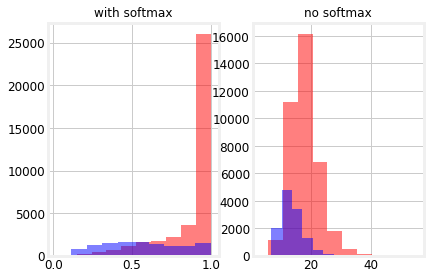

In [5]:
preds_max_val = np.max(scipy.special.softmax(preds_val, axis=1), axis=1)
preds_max_class_v = np.argmax(preds_val, axis=1)
labs = labs_val

plt.subplot(121)
plt.title('with softmax')
plt.hist(preds_max_val[preds_max_class_val == labs_val], color='red', alpha=0.5)
plt.hist(preds_max_val[preds_max_class_val != labs_val], color='blue', alpha=0.5)

plt.subplot(122)
plt.title('no softmax')
preds_max_val = np.max(preds_val, axis=1)
plt.hist(preds_max_val[preds_max_class_val == labs_val], color='red', alpha=0.5)
plt.hist(preds_max_val[preds_max_class_val != labs_val], color='blue', alpha=0.5)
plt.show()

# look at features

In [ ]:
sims = metrics.pairwise.cosine_similarity(feats_train)
print(sims.shape)

# pairwise pred plots

mean: 0.65, [0.8431166909614919, 0.840097846091936, 0.7155312751603533, 0.673810948664757, 0.5596489991216772, 0.6599716554930394, 0.7514585257933221, 0.4732741840483416, 0.5005053597969736, 0.5279050558430235]


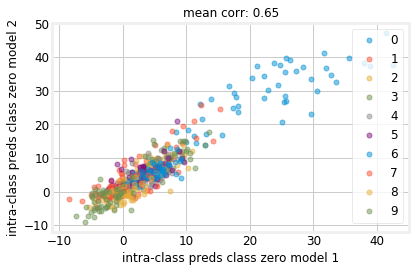

In [29]:
# ['alexnet.h5', 'alexnet_feats.h5', 'densenet169.h5', 'labs.h5', 'resnet18.h5', 
# 'resnet50.h5', 'top_10_inds_dict.pkl', 'vgg11.h5', 'vgg13.h5', 'vgg16.h5', 'vgg19.h5']
p1 = np.array(h5py.File(oj(out_dir, 'alexnet.h5'), 'r')['preds_val'])
p2 = np.array(h5py.File(oj(out_dir, 'vgg11.h5'), 'r')['preds_val'])

for lab_num in range(10):
    plt.plot(p1[labs_val==lab_num][:, 0], 
             p2[labs_val==lab_num][:, 0], '.', alpha=0.5, label=str(lab_num))
plt.legend()
plt.xlabel('intra-class preds class zero model 1')
plt.ylabel('intra-class preds class zero model 2')
corrs = []
for lab_num in range(10):
    corrs.append(np.corrcoef(p1[labs_val==lab_num][:, 0], p2[labs_val==lab_num][:, 0])[0, 1])
print(f'mean: {np.mean(corrs):.2f}, {corrs}')
plt.title(f'mean corr: {np.mean(corrs):.2f}')
plt.tight_layout()
plt.savefig('imagenet_intra_class_preds_class=0.png', dpi=300)

mean: 0.71, [0.8218758393844797, 0.7498030230372421, 0.7167978155486561, 0.6255460842416168, 0.36764233551045594, 0.8680667679882752, 0.8144059235220529, 0.7043089636523435, 0.7538610381867796, 0.6880315451771803]


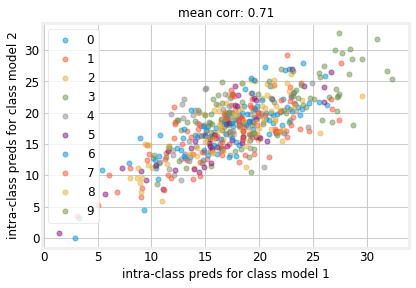

In [34]:
# ['alexnet.h5', 'alexnet_feats.h5', 'densenet169.h5', 'labs.h5', 'resnet18.h5', 
# 'resnet50.h5', 'top_10_inds_dict.pkl', 'vgg11.h5', 'vgg13.h5', 'vgg16.h5', 'vgg19.h5']
p1 = np.array(h5py.File(oj(out_dir, 'densenet169.h5'), 'r')['preds_val'])
p2 = np.array(h5py.File(oj(out_dir, 'resnet50.h5'), 'r')['preds_val'])

for lab_num in range(10):
    plt.plot(p1[labs_val==lab_num][:, lab_num], 
             p2[labs_val==lab_num][:, lab_num], '.', alpha=0.5, label=str(lab_num))
plt.legend()
plt.xlabel('intra-class preds for class model 1')
plt.ylabel('intra-class preds for class model 2')
corrs = []
for lab_num in range(10):
    corrs.append(np.corrcoef(p1[labs_val==lab_num][:, lab_num], p2[labs_val==lab_num][:, lab_num])[0, 1])
print(f'mean: {np.mean(corrs):.2f}, {corrs}')
plt.tight_layout()
plt.title(f'mean corr: {np.mean(corrs):.2f}')
plt.savefig('imagenet_intra_class_preds.png', dpi=300)

In [13]:
print(preds_val.shape, preds_val2.shape)

(50000, 1000) (50000, 1000)


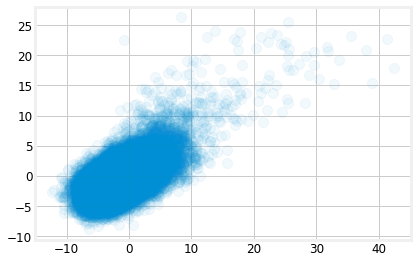

In [17]:
plt.plot(preds_val[:, 0], preds_val2[:, 0], 'o', alpha=0.05)
# plt.plot(scipy.special.softmax(preds_val, axis=1)[:, 0], 
#          scipy.special.softmax(preds_val2, axis=1)[:, 0], 'o', alpha=0.1)
plt.show()

# do different nets put their maxes at the same place?

In [36]:
ind_tops.keys()

dict_keys(['alexnet.h5', 'vgg11.h5', 'vgg13.h5', 'vgg16.h5', 'resnet18.h5', 'densenet169.h5'])

In [35]:
# maxes = []
# ind_tops = {} # these are in ascending order
# for fname in tqdm(['alexnet.h5', 'vgg11.h5', 'vgg13.h5', 'vgg16.h5', 'resnet18.h5', 'densenet169.h5']):
#     preds = h5py.File(oj(out_dir, fname), 'r')['preds_train']
#     maxes.append(np.argmax(preds, axis=0))

#     # get largest indices for each class
# #     ind_top10 = np.argpartition(preds, kth=-10, axis=0)[-10:]
#     ind_top = np.argsort(preds, axis=0) # in ascending order
#     ind_tops[fname] = np.concatenate((ind_top[:10], ind_top[10:50:5], ind_top[50:100:10], ind_top[100:1000:100]))
    
# maxes = np.array(maxes)
# pkl.dump(ind_tops, open(oj(out_dir, "ind_tops.pkl"), "wb" ))

100%|██████████| 6/6 [27:59<00:00, 280.35s/it]


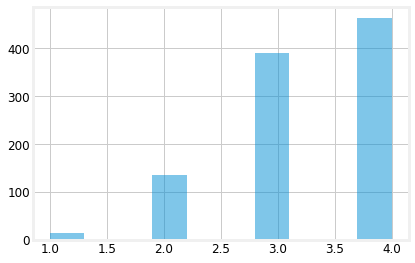

In [82]:
plt.hist(pd.DataFrame(maxes).nunique())
plt.show()

In [72]:
print(np.histogram(pd.DataFrame(maxes[:2]).nunique()))

(array([ 90,   0,   0,   0,   0,   0,   0,   0,   0, 910]), array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]))


In [113]:
maxes.shape
print(maxes[0][:10])
print(top_10_inds['alexnet.h5'][-1, :10])

[  518  2583  2629  5010  5371  7397  8555 10523 10523 11796]
[  518  2583  2629  5010  5371  7397  8555 10523 10523 11796]


In [110]:
top_10_inds.keys()

dict_keys(['alexnet.h5', 'vgg11.h5', 'resnet18.h5', 'densenet169.h5'])

In [37]:
stats.num_agree_topk(top_10_inds['alexnet.h5'], top_10_inds['vgg11.h5'])

NameError: name 'stats' is not defined

In [ ]:
# note: need to pass in ks!
nums_agree = []
nums_agree2 = []
for k in range(1, 11):
    nums_agree.append(num_agree_topk(top_10_inds['alexnet.h5'], top_10_inds['vgg11.h5'], k=k) / 1000)
#     nums_agree2.append(num_agree_topk(top_10_inds['densenet169.h5'], top_10_inds['vgg11.h5'], k=k) / 1000)    
plt.plot(range(1, 11), nums_agree, '.')
# plt.plot(range(1, 11), nums_agree2, '.')
plt.xlabel('Top k to match')
plt.ylabel('Percent agreement between alexnet and vgg11\nbaseline = 1/1000 for k=1')
print(nums_agree2)